In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.io
import scipy.signal

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
np.random.seed(1337)

In [2]:
low_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\10degC\all_second.csv"
mid_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\25degC\all_second.csv"
high_file = r"D:\test_development\Battery\data1\LG_HG2_Original_Dataset_McMasterUniversity_Jan_2020\40degC\all_second.csv"
cols = ['V', 'I', 'T']

In [3]:
def butter(x):
    hz = 1
    b, a = scipy.signal.butter(1, 0.0005/(hz/2))
    x['V0.5m'] = scipy.signal.filtfilt(b, a, x['V'])
    x['I0.5m'] = scipy.signal.filtfilt(b, a, x['I'])
    b, a = scipy.signal.butter(1, 0.005/(hz/2))
    x['V5m'] = scipy.signal.filtfilt(b, a, x['V'])
    x['I5m'] = scipy.signal.filtfilt(b, a, x['I'])
    x.drop(columns=['V', 'I'], inplace=True)

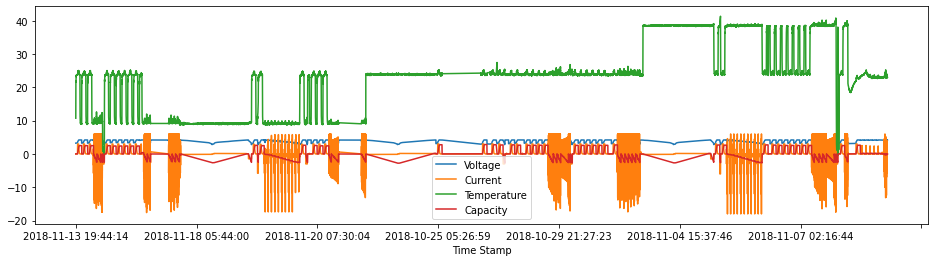

In [4]:
low_df = pd.read_csv(low_file, index_col='Time Stamp')
mid_df = pd.read_csv(mid_file, index_col='Time Stamp')
high_df = pd.read_csv(high_file, index_col='Time Stamp')
df = pd.concat([low_df, mid_df, high_df])
df.plot(figsize=(16, 4), legend=True)
plt.show()

In [5]:
def from_raw(df):
    x = df.copy()

    condition = (x == x.shift()).any(axis=1)

    duplicates = x[condition].groupby((~condition).cumsum())
    for name, df_type in list(duplicates):
        if len(df_type) > 300:
            x.drop(df_type.index, inplace=True)
    x = x.reset_index(drop=True)
    y = pd.DataFrame(x.pop('Capacity'))

    x.columns = cols
    y.columns = ['SOC']

    # minmax = scipy.io.loadmat(minmax_file)
    # x = (x - minmax['MIN'][0]) / (minmax['MAX'][0] - minmax['MIN'][0])
    x = x.apply(lambda row : (row - row.min()) / (row.max() - row.min()))

    y = y / 3 % 1

    butter(x)

    return x, y

x_df, y_df = from_raw(df)

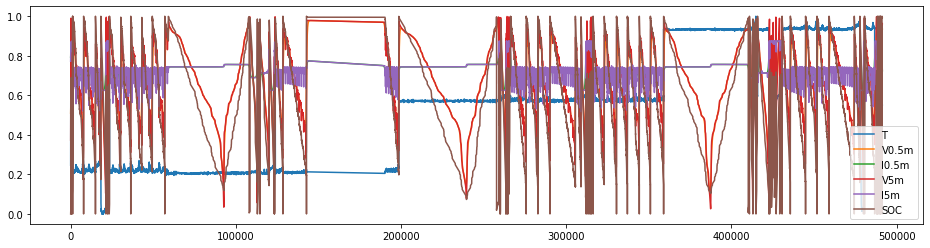

In [6]:
pd.concat([x_df, y_df], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

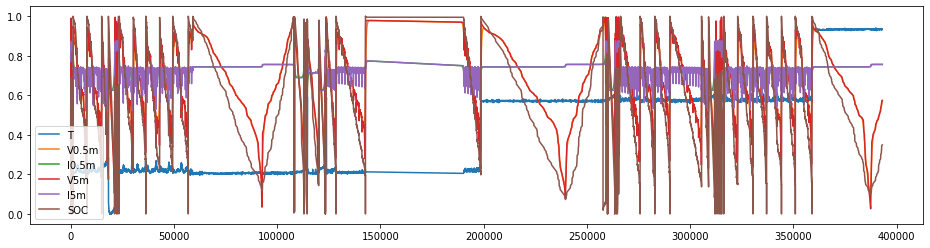

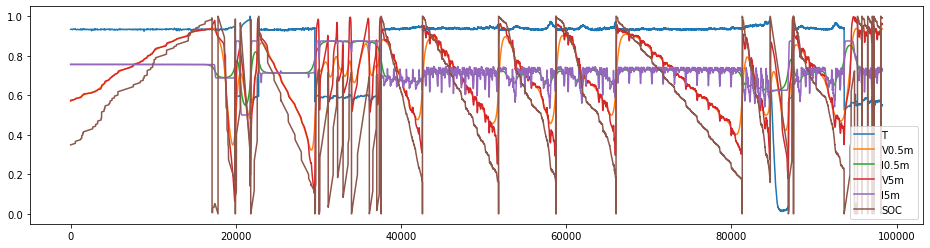

In [7]:
x_train, x_test = train_test_split(x_df, shuffle=False, test_size=0.2)
y_train, y_test = train_test_split(y_df, shuffle=False, test_size=0.2)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

pd.concat([x_train, y_train], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

pd.concat([x_test, y_test], axis=1).plot(figsize=(16, 4), legend=True)
plt.show()

In [227]:
def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(21, activation='relu'),
  tf.keras.layers.Dense(19, activation='relu'),
  tf.keras.layers.Dense(1, activation=clipped_relu)
])

model.compile(optimizer='adam',
              loss='mean_squared_error')

history = model.fit(
  x_train.values,
  y_train.values,
  epochs=50,
  validation_split=0.1,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/50
11055/11055 [==============================] - 14s 1ms/step - loss: 0.0078 - val_loss: 0.0131
Epoch 2/50
11055/11055 [==============================] - 14s 1ms/step - loss: 0.0061 - val_loss: 0.0334
Epoch 3/50
11055/11055 [==============================] - 14s 1ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 4/50
11055/11055 [==============================] - 15s 1ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 5/50
11055/11055 [==============================] - 15s 1ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 6/50
11055/11055 [==============================] - 15s 1ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 7/50
11055/11055 [==============================] - 15s 1ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 8/50
11055/11055 [==============================] - 15s 1ms/step - loss: 0.0046 - val_loss: 0.0036


In [229]:
def test_eva(x, y):
    model.evaluate(x, y)
    prediction = pd.DataFrame(model.predict(x), columns=['predicted SOC'])

    # Visualising the results
    pd.concat([prediction, y], axis=1).plot(figsize=(16, 4), legend=True)
    plt.show()

3071/3071 [==============================] - 3s 828us/step


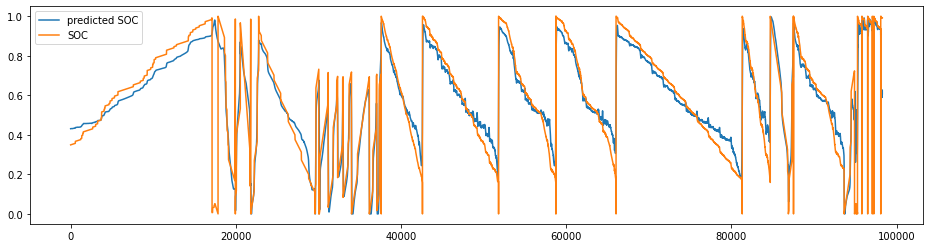

In [230]:
test_eva(x_test, y_test)

In [9]:
# import the model
from sklearn.svm import NuSVR
# create the model object
regressor = NuSVR(C=1.0, gamma=0.125, kernel='rbf', verbose=True)
# fit the model on the data
regressor.fit(x_train, y_train)

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]